# Homework 7 (Part I): Variational Inference with Neural Networks for a toy example


## Student 1: Karolina Sidlauskaite (100392576)
## Student 2: Niall O'Neill (100394545)

Consider a certain number of sensors  placed at known locations, $\mathbf{s}_1,\mathbf{s}_2,\ldots,\mathbf{s}_L$. There is a target at an unknown position $\mathbf{z}\in\mathbb{R}^2$ that is emitting a certain signal that is received at the $i$-th sensor with a signal strength distributed as follows:

\begin{align}
x_i \sim \mathcal{N}\Big(- A \log\left(||\mathbf{s}_i-\mathbf{z} ||^2\right), \sigma^2\Big),
\end{align}

where $A$ is a constant related to how fast signal strength degrades with distance. We assume a Gaussian prior for the unknown position $\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$. Given a set of $N$ i.i.d. samples for each sensor, $\mathbf{X}\in\mathbb{R}^{L\times N}$, we will use  Neural Variational Inference to find a Gaussian approximation to 

\begin{align}
p(\mathbf{z}|\mathbf{X}) \propto  p(\mathbf{X}|\mathbf{z}) p(\mathbf{z})
\end{align}

Our approximation to $p(\mathbf{z}|\mathbf{X})$ is of the form
\begin{align}
p(\mathbf{z}|\mathbf{X}) \approx q(\mathbf{z}|\mathbf{X})=\mathcal{N}\Big(\mu(\mathbf{X}),\Sigma(\mathbf{X})\Big),
\end{align}
where

- $\mu(\mathbf{X})$ --> Given by a Neural Network with parameter vector $\theta$ and input $\mathbf{X}$

- $\Sigma(\mathbf{X})$ --> Diagonal covariance matrix, where the log of the main diagonal is constructed by a Neural Network with parameter vector $\gamma$ and input $\mathbf{X}$

**Note:**  $\mathbf{X}$ is reshaped into a $L\times N$ to input both $\mu(\mathbf{X})$ and $\Sigma(\mathbf{X})$

## ELBO lower-bound to $p(\mathbf{X})$

We will optimize $q(\mathbf{z}|\mathbf{X})$ w.r.t. $\theta,\gamma$ by optimizing the Evidence-Lower-Bound (ELBO):

\begin{align}
p(\mathbf{X}) &= \int p(\mathbf{X}|\mathbf{z}) p(\mathbf{z}) d\mathbf{z}\\
&\geq \int q(\mathbf{X}|\mathbf{z}) \log \left(\frac{p(\mathbf{X},\mathbf{z})}{q(\mathbf{X}|\mathbf{z})}\right)d\mathbf{z}\\
& = \mathbb{E}_{q}\left[\log  p(\mathbf{X}|\mathbf{z})\right] - D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})\triangleq \mathcal{L}(\mathbf{X},\theta,\gamma),
\end{align}
where $D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})$ is known in closed form since it is the KL divergence between two Gaussian pdfs:

\begin{align}
D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})) = \frac{1}{2} \left[\text{tr}\left(\Sigma(\mathbf{X})\right)+\left(\mu(\mathbf{X})^T\mu(\mathbf{X})\right)-2-\log\det \left(\Sigma(\mathbf{X})\right) \right]
\end{align}

## SGD optimization

- Sample $\mathbf{\epsilon}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$
- Sample from $q(\mathbf{z}|\mathbf{X})$:
\begin{align}
\mathbf{z}^0 = \mu(\mathbf{X}) + \sqrt{\text{diag}(\Sigma(\mathbf{X}))} \circ \mathbf{\epsilon}
\end{align}
- Compute gradients of 
\begin{align}
\hat{\mathcal{L}}(\mathbf{X},\theta,\gamma) =\log  p(\mathbf{X}|\mathbf{z}^0) - D_{KL}\left(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})\right)
\end{align}

w.r.t. $\theta,\gamma$. Note that, since the whole sample matrix is reshaped into a $L\times N$ to input both $\mu(\mathbf{X})$ and $\Sigma(\mathbf{X})$, in this toy example **we do not use minibatches**! 




In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
%matplotlib inline

# use seaborn plotting defaults
import seaborn as sns; sns.set()

### Probabilistic model definition and generating samples

We assume that all parameteres in the probabilistic model are known. To generate the sample matrix $\mathbf{X}$, we fix the target position. Our goal is to run the inference method to estimate the target position exclusively from $\mathbf{X}$.

In [27]:
############## Elements of the true probabilistic model ####################

loc_info = {}                           

# Number o sensors
loc_info['L'] = 3 

# Number o sensors
loc_info['z_dim'] = 2 

#Position of sensors
loc_info['pos_s'] = np.array([[0.5,1], [3.5,1], [2,3]]).astype(np.float32) 

# Target position (This is what we try to infer)
loc_info['target'] = np.array([-1,2]).astype(np.float32)  

#Variance of sensors (parameter sigma^2 in the probabilistic model)
loc_info['var_s'] = 5.*np.ones(loc_info['L']).reshape([loc_info['L'],1]).astype(np.float32) 

#Attenuation factor per sensor (parameter A in the probabilistic model)
loc_info['A'] = 10.0*np.ones(loc_info['L'],dtype=np.float32)

# Number of measurements per sensor
loc_info['N'] = 5 


# Function to sample from the generative model
def sample_X(L,M,z,pos_s,A,var_s):
    
    means = -1*A*np.log(np.sum((pos_s-z)**2,1))
    
    X = means.reshape([L,1]) + np.random.randn(L,M) * np.sqrt(var_s)
    
    return X


Sampling $\mathbf{X}$ ...

In [28]:
X = sample_X(loc_info['L'],loc_info['N'], loc_info['target'],loc_info['pos_s'],loc_info['A'],loc_info['var_s']).astype(np.float32)

Lets plot the 2D scenario

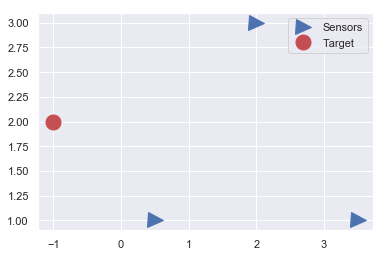

In [29]:
plt.plot(loc_info['pos_s'][:,0],loc_info['pos_s'][:,1],'b>',label='Sensors',ms=15)
plt.plot(loc_info['target'][0],loc_info['target'][1],'ro',label='Target',ms=15)
plt.legend()

### Step 1: Defintion of the NNs that define the posterior mean and covariance matrix (1 point)

Given $\mathbf{X}$ (reshaped into a $L\times N$ vector), we will train two NNs to estimate both the mean and covariance matrix of the approximation to the posterior $q(\mathbf{z}|\mathbf{X})$. We assume a diagonal covariance matrix. In this way, the NN provides the diagonal of the covariance matrix.

Each NN has one hidden layer with an hiperbolic tangent activation and no output activation. Since the diagonal of the covariance matrix can only contain positive numbers, we assume the network outpus the **logarithm of the diagonal of the covariance matrix variance**.

In [30]:
class Posterior_moments(nn.Module):
    def __init__(self,loc_info,hidden_dim):
        super().__init__()
        
        #z_dim=2 in our 2D-localization problem, but we leave
        #as a free parameter
        
        # Inputs to hidden layer linear transformation
        self.hidden_mean = nn.Linear(loc_info['L']*loc_info['N'],
                                hidden_dim)
        
        self.hidden_var = nn.Linear(loc_info['L']*loc_info['N'],
                                hidden_dim)        
        
        # Mean linear layer
        self.output_mean = nn.Linear(hidden_dim, loc_info['z_dim'])
        # Diagonal variance linear layer
        self.output_logvar = nn.Linear(hidden_dim, loc_info['z_dim'])

        self.activation = nn.Tanh()
        
        
        
    def forward(self, x):
        
        # Complete the forward method.
        
        self.mean = self.hidden_mean(x)
        self.mean = self.activation(self.mean)
        self.mean = self.output_mean(self.mean)
        
        
        self.log_var = self.hidden_var(x)
        self.log_var = self.activation(self.log_var)
        self.log_var = self.output_logvar(self.log_var)

### Step 2: Create a class to evaluate the loss function (ELBO) (3 points)

Lets create a new class inherited from ``Posterior_moments`` that incorporates two new methods: one to sample from $q(\mathbf{z}|\mathbf{X})$ and one to evaluate the ELBO. Recall that to sample from from $q(\mathbf{z}|\mathbf{X})$, we first sample from $\mathbf{\epsilon}\sim\mathcal{N}(\mathbf{0},\mathbf{I})$ and then

\begin{align}
\mathbf{z}^0 = \mu(\mathbf{X}) + \sqrt{\text{diag}(\Sigma(\mathbf{X}))} \circ \mathbf{\epsilon}
\end{align}

In [31]:
class Variational_Loss(Posterior_moments):
    
    def __init__(self,loc_info,hidden_dim):
        super().__init__(loc_info,hidden_dim)
        
        self.loc_info = loc_info
        
        
    def sample_from_q(self,x):
        
        self.forward(x)
        
        # Sampling from q(z|x). 
        # We first sample from N(0,I)
        # Then, scale by std vector and sum the mean
        
        noise = torch.FloatTensor(x.shape[0], 1).normal_()
        
        self.sample = self.mean + torch.exp(self.log_var.diagonal())**0.5 * noise
        
        
    def ELBO(self,x):
          
        self.sample_from_q(x)

        # KL divergence ELBO regularizer
        
        self.KL = -0.5*self.loc_info['z_dim']+0.5*torch.sum(
                torch.exp(self.log_var)+self.mean**2-self.log_var)
        
        # Evaluate log-likelihood for the current z sample
        # To do this we use the probabilistic model!

        # Signal mean per sensor
        self.means = (-torch.from_numpy(self.loc_info['A'])*
                                  torch.log(torch.sum((torch.from_numpy(self.loc_info['pos_s'])-self.sample)**2,1)))
        
        # Unnormalized likelihood
        log_lik = -0.5 * (x.reshape([self.loc_info['L'],-1])-self.means.reshape([-1,1]))**2/torch.from_numpy(self.loc_info['var_s'])
    
        #Normalizing constant (not important for inference)
        log_lik += -0.5*torch.log(torch.from_numpy(self.loc_info['var_s']))
            
        self.log_lik = torch.sum(log_lik)
        
        self.ELBO_loss = -(self.log_lik-self.KL)
            
        return self.ELBO_loss

### Step 3: Create a class to perform ELBO optimization (3 points)

Create a new class inherited from `Variational_Loss` that implements a method to perform a SGD step over the variational bound (ELBO)

In [32]:
class neural_variational_localization(Variational_Loss):
    
    def __init__(self,loc_info,hidden_dim):
        
        super().__init__(loc_info,hidden_dim)
        
        self.optimizer = optim.Adam(self.parameters(),lr=1e-2)
        
    # One SGD 
    def SGD_step(self,x):
        self.optimizer.zero_grad()
        loss = self.ELBO(x)
        loss.backward()
        self.optimizer.step()
    

### Step 4: Training the inference model (1 point)

In [33]:
hidden_dim = 50

m = neural_variational_localization(loc_info,hidden_dim)

In [34]:
SGD_steps = 10000

period_plot = 1000

x = torch.from_numpy(X.reshape([1,-1]))

for step in range(SGD_steps):
    output = m.SGD_step(x)
    
    if(step % period_plot == 0):
        
        print("Step = %d, loglik = %.5f, KL = %.5f, ELBO = %.5f" 
              %(step,m.log_lik,m.KL,m.ELBO_loss))

        

Step = 0, loglik = -175.13181, KL = 0.81801, ELBO = 175.94981
Step = 1000, loglik = -15.73142, KL = 4.55047, ELBO = 20.28189
Step = 2000, loglik = -15.71573, KL = 4.18160, ELBO = 19.89734
Step = 3000, loglik = -17.79975, KL = 4.81947, ELBO = 22.61922
Step = 4000, loglik = -20.12002, KL = 4.07213, ELBO = 24.19215
Step = 5000, loglik = -15.58954, KL = 4.78144, ELBO = 20.37098
Step = 6000, loglik = -15.93099, KL = 4.72338, ELBO = 20.65437
Step = 7000, loglik = -16.57527, KL = 4.01668, ELBO = 20.59194
Step = 8000, loglik = -15.93044, KL = 4.30297, ELBO = 20.23341
Step = 9000, loglik = -16.09553, KL = 4.42101, ELBO = 20.51654


### Step 5: Compare posterior distribution with actual target position (2 points)

[[-0.98348784  2.3735945 ]]
[[4.3760428e+00 1.4901161e-08]]


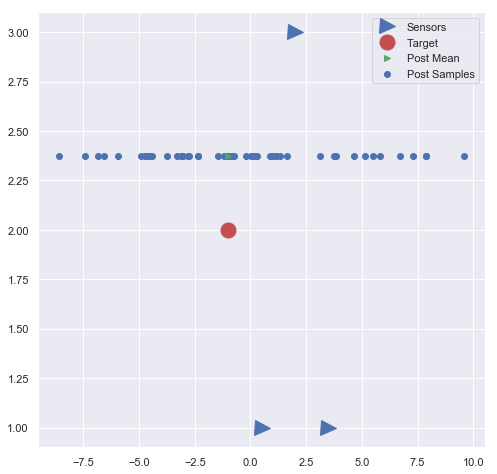

In [38]:
# Posterior mean after training (use .detach().numpy() to convert to numpy)
m_final = m.mean.detach().numpy()

# Posterior covariance matrix after training
log_var_final = abs(m.log_var.detach().numpy())

nsamples = 50
#Obtain nsamples from q(z|x)
samplesx = np.random.normal(m_final[0][0],log_var_final[0][0], nsamples)
samplesy = np.random.normal(m_final[0][1],log_var_final[0][1], nsamples)

samples = np.column_stack((samplesx, samplesy))


plt.plot(loc_info['pos_s'][:,0],loc_info['pos_s'][:,1],'b>',label='Sensors',ms=15)
plt.plot(loc_info['target'][0],loc_info['target'][1],'ro',label='Target',ms=15)
plt.plot(m_final[:,0],m_final[:,1],'g>',label='Post Mean')
plt.scatter(samples[:,0],samples[:,1],label='Post Samples')
plt.rcParams["figure.figsize"] = [8,8]
plt.legend()